In [173]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from matplotlib import pyplot as plt
plt.style.use('ggplot')

import seaborn as sns
import os
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
import pickle as pkl
from collections import defaultdict

from scipy.sparse import csr_matrix, hstack, vstack, coo_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV, train_test_split, TimeSeriesSplit
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb
import lightgbm as lgbm
import catboost as cb

In [174]:
PATH_TO_DATA = ('./data')
train_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_sessions.csv'), index_col='session_id')
test_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'test_sessions.csv'), index_col='session_id')

In [3]:
site_dict = pkl.load(open('./data/site_dic.pkl', 'rb'))
site_dict_inv = defaultdict(str, [(v, k) for (k, v) in site_dict.items()])

In [175]:
train_df.sort_values(by='time1', inplace=True)

In [176]:
train_df.shape, test_df.shape

((253561, 21), (82797, 20))

In [177]:
X = train_df.drop('target', axis=1)
test = test_df.copy()

In [178]:
y = train_df['target']

### preprocessing

In [179]:
times = ['time%s' % i for i in np.arange(1, 11)]
sites = ['site%s' % i for i in np.arange(1, 11)]

In [180]:
alice_sites_count = defaultdict(int)
for row in tqdm_notebook(train_df[train_df['target'] == 1][sites].fillna(0).values):
    for site in row:
        if site != 0:
            alice_sites_count[int(site)] += 1
alice_sites_all = sorted([(k, v) for (k, v) in alice_sites_count.items()], key=lambda x: x[1], reverse=True)

HBox(children=(IntProgress(value=0, max=2297), HTML(value='')))

In [181]:
X[times] = X[times].fillna(0).apply(pd.to_datetime)
test[times] = test[times].fillna(0).apply(pd.to_datetime)

X[sites] = X[sites].fillna(0).astype('int')
test[sites] = test[sites].fillna(0).astype('int')

In [182]:
X['all_sites'] = X[sites].apply(lambda row: ' '.join(str(r) for r in row), axis=1)
test['all_sites'] = test[sites].apply(lambda row: ' '.join(str(r) for r in row), axis=1)

### tf-idf

In [183]:
tf_idf = TfidfVectorizer(ngram_range=(1, 7), max_features=200000, max_df=.5)
tf_idf.fit(X['all_sites'])
X_tfidf = tf_idf.transform(X['all_sites'])
test_tfidf = tf_idf.transform(test['all_sites'])

### feature engineering

In [184]:
hours = ['hour%s' % i for i in np.arange(1, 11)]
X[hours] = X[times].apply(lambda x: [h.hour for h in x], axis=1)
test[hours] = test[times].apply(lambda x: [h.hour for h in x], axis=1)

In [185]:
def get_duration(row):
    zero = np.datetime64('1970-01-01T00:00:00.000000000')
    cor = [r for r in row if r != zero]
    diff = (cor[-1] - cor[0])
    return diff
    
X['duration'] = X[times].apply(lambda x: get_duration(x).total_seconds(), axis=1)
test['duration'] = test[times].apply(lambda x: get_duration(x).total_seconds(), axis=1)

In [186]:
X['weekday'] = X['time1'].apply(lambda x: x.weekday())
test['weekday'] = test['time1'].apply(lambda x: x.weekday())

In [188]:
alice_top_sites = [i[0] for i in alice_sites_all][:20]

alice_sites = ['site_%s' % site for site in alice_top_sites]

for site in tqdm_notebook(alice_top_sites):
    X['site_%s' % site] = X[sites].apply(lambda x: any([xi == site for xi in x]), axis=1).astype(int)
    test['site_%s' % site] = test[sites].apply(lambda x: any([xi == site for xi in x]), axis=1).astype(int)

HBox(children=(IntProgress(value=0, max=20), HTML(value='')))

In [189]:
X['YYYYMM'] = X['time1'].apply(lambda x: x.year * 100 + x.month)
test['YYYYMM'] = test['time1'].apply(lambda x: x.year * 100 + x.month)

In [190]:
def is_worktime(hour, weekday):
    if weekday == 6:
        return 0
    if (hour >= 9 and hour <= 13) or (hour >= 15 and hour <= 18):
        return 1
    return 0

X['worktime'] = X['time1'].apply(lambda x: is_worktime(x.hour, x.weekday()))
test['worktime'] = test['time1'].apply(lambda x: is_worktime(x.hour, x.weekday()))

In [191]:
def is_holiday(month):
    if month in (9, 10, 11, 12, 1, 2, 3, 4, 5):
        return 0
    else:
        return 1
    
X['holiday'] = X['time1'].apply(lambda x: is_holiday(x.month))
test['holiday'] = test['time1'].apply(lambda x: is_holiday(x.month))

In [204]:
zero = np.datetime64('1970-01-01T00:00:00.000000000')
time_diffs = ['time_diff%s' % i for i in np.arange(1, 10)]
for i in tqdm_notebook(np.arange(1, 10)):
    X['time_diff%s' % i] = X['time%s' % (i + 1)] - X['time%s' % i]
    X['time_diff%s' % i] = X['time_diff%s' % i].apply(lambda x: x.total_seconds() if x.total_seconds() > 0 else 0)
    X['time_diff%s' % i] = X['time_diff%s' % i].apply(np.log1p)
    test['time_diff%s' % i] = test['time%s' % (i + 1)] - test['time%s' % i]
    test['time_diff%s' % i] = test['time_diff%s' % i].apply(lambda x: x.total_seconds() if x.total_seconds() > 0 else 0)
    test['time_diff%s' % i] = test['time_diff%s' % i].apply(np.log1p)

HBox(children=(IntProgress(value=0, max=9), HTML(value='')))

In [193]:
X['unique'] = X[sites].apply(lambda x: len(np.unique([i for i in x if i > 0])), axis=1)
test['unique'] = test[sites].apply(lambda x: len(np.unique([i for i in x if i > 0])), axis=1)

In [205]:
X

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,unique
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55,2013-01-12 08:05:57,0,1970-01-01 00:00:00,0,1970-01-01 00:00:00,0,1970-01-01 00:00:00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2
54843,56,2013-01-12 08:37:23,55,2013-01-12 08:37:23,56,2013-01-12 09:07:07,55,2013-01-12 09:07:09,0,1970-01-01 00:00:00,...,0.000000,7.487174,1.098612,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2
77292,946,2013-01-12 08:50:13,946,2013-01-12 08:50:14,951,2013-01-12 08:50:15,946,2013-01-12 08:50:15,946,2013-01-12 08:50:16,...,0.693147,0.693147,0.000000,0.693147,0.000000,0.000000,0.000000,0.693147,0.000000,6
114021,945,2013-01-12 08:50:17,948,2013-01-12 08:50:17,949,2013-01-12 08:50:18,948,2013-01-12 08:50:18,945,2013-01-12 08:50:18,...,0.000000,0.693147,0.000000,0.000000,0.000000,0.693147,0.000000,0.000000,0.693147,5
146670,947,2013-01-12 08:50:20,950,2013-01-12 08:50:20,948,2013-01-12 08:50:20,947,2013-01-12 08:50:21,950,2013-01-12 08:50:21,...,0.000000,0.000000,0.693147,0.000000,0.000000,0.000000,0.693147,0.000000,0.000000,6
242171,952,2013-01-12 08:50:22,947,2013-01-12 08:50:23,953,2013-01-12 08:50:23,946,2013-01-12 08:50:23,947,2013-01-12 08:50:24,...,0.693147,0.000000,0.000000,0.693147,0.000000,0.000000,0.000000,0.693147,0.000000,5
57157,953,2013-01-12 08:50:25,947,2013-01-12 08:50:26,946,2013-01-12 08:50:26,953,2013-01-12 08:50:26,955,2013-01-12 08:50:26,...,0.693147,0.000000,0.000000,0.000000,0.693147,0.000000,0.000000,0.693147,0.000000,5
240201,946,2013-01-12 08:50:28,947,2013-01-12 08:50:28,954,2013-01-12 08:50:28,953,2013-01-12 08:50:29,946,2013-01-12 08:50:29,...,0.000000,0.000000,0.693147,0.000000,0.000000,0.693147,0.000000,0.693147,0.000000,6
210686,946,2013-01-12 08:50:31,956,2013-01-12 08:50:32,946,2013-01-12 08:50:32,946,2013-01-12 08:50:33,955,2013-01-12 08:50:33,...,0.693147,0.000000,0.693147,0.000000,0.000000,0.693147,0.693147,0.693147,0.000000,5


### Stacking

In [206]:
ohe_columns = hours + ['weekday']
numeric_columns = ['duration', 'YYYYMM'] + time_diffs
binary_columns = alice_sites + ['worktime', 'holiday']

In [207]:
ohe = OneHotEncoder(handle_unknown='ignore')
ohe.fit(X[ohe_columns])
X_ohe = ohe.transform(X[ohe_columns])
test_ohe = ohe.transform(test[ohe_columns])

ss = StandardScaler()
ss.fit(X[numeric_columns].append(test[numeric_columns]))
X_numeric = ss.transform(X[numeric_columns])
test_numeric = ss.transform(test[numeric_columns])

X_binary = X[binary_columns]
test_binary = test[binary_columns]

In [208]:
X_all = hstack([X_tfidf, X_binary, X_numeric, X_ohe]).tocsr()
test_all = hstack([test_tfidf, test_binary, test_numeric, test_ohe]).tocsr()

### Validating

In [199]:
def get_auc_lr_valid(X, y, C=1.0, seed=17, ratio=0.7):
    # Split the data into the training and validation sets
    idx = int(round(X.shape[0] * ratio))
    # Classifier training
    lr = LogisticRegression(C=C, random_state=seed, n_jobs=-1).fit(X[:idx, :], y[:idx])
    # Prediction for validation set
    y_pred_val = lr.predict_proba(X[idx:, :])[:, 1]
    y_pred_train = lr.predict_proba(X[:idx, :])[:, 1]
    # Calculate the quality
    score_val = roc_auc_score(y[idx:], y_pred_val)
    score_train = roc_auc_score(y[:idx], y_pred_train)
    return (score_train, score_val)

In [209]:
%%time
print(get_auc_lr_valid(X_all, y))

(0.9919681257698901, 0.9589510137810289)
CPU times: user 19.3 s, sys: 724 ms, total: 20 s
Wall time: 10.1 s


In [201]:
train_score = []
val_score = []
cv_score = []
C = [0.1, 1, 2, 3, 4, 5, 6, 10, 20]
for c in tqdm_notebook(C):
    # cv_score.append(cross_val_score(LogisticRegression(C=c, random_state=7, n_jobs=-1), X_all, y, scoring='roc_auc',
    #            cv=split, n_jobs=-1).mean())
    score = get_auc_lr_valid(X_all, y , C=c)
    train_score.append(score[0])
    val_score.append(score[1])

HBox(children=(IntProgress(value=0, max=9), HTML(value='')))

Text(0.5,0,'C')

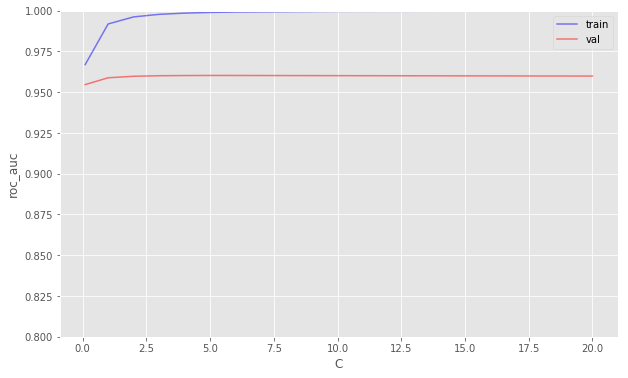

In [202]:
(fig, ax) = plt.subplots(figsize=(10, 6))
ax.plot(C, train_score, alpha=0.5, color='blue', label='train')
ax.plot(C, val_score, alpha=0.5, color='red', label='val')
# ax.plot(C, cv_score, alpha=0.5, color='green', label='cv')
ax.legend(loc='best')
ax.set_ylim([0.8, 1])
ax.set_ylabel('roc_auc')
ax.set_xlabel('C')

In [203]:
list(zip(zip(C, train_score),\
         zip(C, val_score)))

[((0.1, 0.9669188270824306), (0.1, 0.9546519364766233)),
 ((1, 0.9918350556117635), (1, 0.9588341533782755)),
 ((2, 0.9961620496091477), (2, 0.9597492191656284)),
 ((3, 0.9977288022696924), (3, 0.9600824624845268)),
 ((4, 0.9984824152970702), (4, 0.9602015563708444)),
 ((5, 0.998900138114834), (5, 0.9602523586580147)),
 ((6, 0.9991531733875414), (6, 0.9602451282281717)),
 ((10, 0.9995429014955395), (10, 0.9601347222143619)),
 ((20, 0.9997335960867848), (20, 0.9598818653759453))]

In [84]:
list(zip(zip(C, train_score),\
         zip(C, val_score)))

[((0.1, 0.967998559421231), (0.1, 0.9553110980454426)),
 ((1, 0.9918689420698372), (1, 0.9595228234290987)),
 ((2, 0.9958105608712139), (2, 0.9603110727767938)),
 ((3, 0.997308521848975), (3, 0.9605415379960887)),
 ((4, 0.9980896059543163), (4, 0.9605923781389127)),
 ((5, 0.9985504518101795), (5, 0.960544358242284)),
 ((6, 0.9988496486102889), (6, 0.9604496244690769)),
 ((10, 0.9993717380143138), (10, 0.9600962608702747)),
 ((20, 0.9996532061376828), (20, 0.9594218813286963))]

### fit model and make prediction

In [145]:
%%time
lr = LogisticRegression(random_state=17, n_jobs=-1, C=4)
test_pred = lr.predict_proba(test_all)[:, 1]

CPU times: user 43.4 s, sys: 1.58 s, total: 44.9 s
Wall time: 22.6 s


In [98]:
test_pred

array([7.52440267e-07, 1.58840715e-08, 2.64550808e-05, ...,
       1.65258183e-06, 1.64171194e-07, 3.27533236e-09])

In [87]:
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [146]:
write_to_submission_file(test_pred,
                         './submissions/lr_c4_final.csv')